In [1]:
from pathlib import Path
from datetime import datetime
import json

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
sns.reset_defaults()
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [4]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.meta_experiment import *
from zscomm.vary_play_param_experiment import *
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Load Data:

In [5]:
NUM_CLASSES = 3
BATCH_SIZE = 32
CHANNEL_SIZE = 5
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [6]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

# Run Experiments

In [8]:
def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE, 'p_mutate': p_mutate,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE, 'p_mutate': p_mutate,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class
    )

def create_self_play_experiment(p_mutate=0.3, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE, 
        'p_mutate': p_mutate,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        **exp_kwargs
    )

def create_unkind_mutation_experiment(p_mutate=0.3, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate, 
        'kind_mutations': False,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        **exp_kwargs
    )

def create_mutation_with_temp_annealing_experiment(
    p_mutate=0.3, channel_size=5, epochs=250, **exp_kwargs
):
    agent = Agent(channel_size, NUM_CLASSES)

    start_temp = 10
    end_temp = 0.1
    temp_anneal_end_epoch = 200
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': p_mutate,
            'channel_temp': channel_temp,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        max_epochs=epochs,
        lr=1e-2,
        step_print_freq=10,
        **exp_kwargs
    )

## Investigating the effect of message mutation:

In [9]:
BASE_FOLDER = './experiments/message_mutation_1'
Path(BASE_FOLDER).mkdir(exist_ok=True)
# EXPERIMENT_FOLDER = f'{BASE_FOLDER}/{datetime.now().strftime("%d-%m_%H-%M")}'

# EXPERIMENT_FOLDER = "./experiments/message_mutation_3"
# EXPERIMENT_FOLDER = "./experiments/message_mutation_1/24-09_09-40"
# EXPERIMENT_FOLDER = "./experiments/message_mutation_1/03-10_02-03"

# EXPERIMENT_FOLDER = "./experiments/message_mutation_1/05-10_03-00"
# EXPERIMENT_FOLDER = './experiments/message_mutation_LAC/07-10_20-16'
EXPERIMENT_FOLDER = "./experiments/message_mutation_1/09-10_02-05"
Path(EXPERIMENT_FOLDER).mkdir(exist_ok=True)
EXPERIMENT_FOLDER

'./experiments/message_mutation_1/09-10_02-05'

In [10]:
vary_pm_experiment = VaryPlayParamExperiment(save_location=EXPERIMENT_FOLDER,
                                             param_vals=[0.0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0],
                                             param_name='p_mutate',
                                             max_epochs=50,
                                             num_experiments_per_val=3,
                                             create_experiment_fn=create_self_play_experiment)

In [188]:
vary_pm_experiment.run()

Running vary_pm_experiment...
meta_experiment_p_mutate=0.0 results:  [0.35625, 0.2875, 0.39375, 0.2625, 0.35, 0.26875]
meta_experiment_p_mutate=0.2 results:  [1.0, 1.0, 0.8875, 0.9625000000000001, 1.0, 1.0]
meta_experiment_p_mutate=0.6 results:  [0.925, 0.66875, 0.9375, 0.66875, 0.7375, 0.7250000000000001]
meta_experiment_p_mutate=0.8 results:  [0.35625, 0.69375, 0.3125, 0.6, 0.69375, 0.59375]
meta_experiment_p_mutate=1.0 results:  [0.44375, 0.45625, 0.47500000000000003, 0.4125, 0.36875, 0.4125]
meta_experiment_p_mutate=0.1 results:  [0.775, 0.4625, 1.0, 1.0, 0.86875, 1.0]
meta_experiment_p_mutate=0.3 results:  [1.0, 0.9, 1.0, 1.0, 1.0, 1.0]
meta_experiment_p_mutate=0.4 results:  [0.75625, 1.0, 0.59375, 0.63125, 1.0, 0.65625]
meta_experiment_p_mutate=0.5 results:  [0.775, 0.7125, 0.7250000000000001, 0.8000000000000002, 0.60625, 0.7625]
meta_experiment_p_mutate=0.7 results:  [0.85, 0.64375, 0.8375, 0.70625, 0.70625, 0.60625]
meta_experiment_p_mutate=0.9 results:  [0.4375, 0.33125, 0.418

In [153]:
grand_total = 0
for item_1 in vary_pm_experiment.experiments:
    for item_2 in item_1['experiment'].experiments:
        total_time = sum([
            x['seconds_taken']
            for x in item_2['experiment'].training_history
        ])
        print(int(total_time / 3600), 'hours,', int(total_time / 60) % 60, 'mins and', 
              int(total_time) % 60, 'seconds taken for experiment', 
              f"pm={item_1['p_mutate']}_{item_2['index']}")
        grand_total += total_time
    print()
    
print(int(grand_total / 3600), 'hours,', int(grand_total / 60) % 60, 'mins and', 
      int(grand_total) % 60, 'seconds taken for whole experiment')

0 hours, 11 mins and 56 seconds taken for experiment pm=0.0_0
0 hours, 11 mins and 5 seconds taken for experiment pm=0.0_1
0 hours, 11 mins and 19 seconds taken for experiment pm=0.0_2

0 hours, 11 mins and 4 seconds taken for experiment pm=0.2_0
0 hours, 11 mins and 9 seconds taken for experiment pm=0.2_1
0 hours, 11 mins and 19 seconds taken for experiment pm=0.2_2

0 hours, 11 mins and 7 seconds taken for experiment pm=0.6_0
0 hours, 11 mins and 7 seconds taken for experiment pm=0.6_1
0 hours, 10 mins and 59 seconds taken for experiment pm=0.6_2

0 hours, 11 mins and 5 seconds taken for experiment pm=0.8_0
0 hours, 11 mins and 24 seconds taken for experiment pm=0.8_1
0 hours, 11 mins and 6 seconds taken for experiment pm=0.8_2

0 hours, 11 mins and 12 seconds taken for experiment pm=1.0_0
0 hours, 11 mins and 15 seconds taken for experiment pm=1.0_1
0 hours, 11 mins and 23 seconds taken for experiment pm=1.0_2

0 hours, 10 mins and 38 seconds taken for experiment pm=0.1_0
0 hours, 1

In [189]:
try:
    zs_coord_df = pd.DataFrame([
        {
            'Mutation Probability': item['p_mutate'],
            'Zero-Shot Coordination Score': score,
        }
        for item in vary_pm_experiment.experiments
        if item['status'] == 'Complete'
        for score in item['results']['zs_coord_f1_scores']
    ])
except:
    zs_coord_df = pd.DataFrame([
        {
            'Mutation Probability': item['p_mutate'],
            'Zero-Shot Coordination Score': metric['ground_truth_acc'],
        }
        for item in vary_pm_experiment.experiments
        if item['status'] == 'Complete'
        for stranger_encounter in item['results']
        for metric in stranger_encounter['vanilla_params_test_metrics']
    ])
zs_coord_df.head()

,Mutation Probability,Zero-Shot Coordination Score
0,0.0,0.35625
1,0.0,0.28750
2,0.0,0.39375
3,0.0,0.26250
4,0.0,0.35000


In [190]:
try:
    self_play_df = pd.DataFrame([
        {
            'Mutation Probability': item_1['p_mutate'],
            'Self-play Performance': item_2['results']['mean_ground_truth_f1'],
        }
        for item_1 in vary_pm_experiment.experiments
        if item_1['status'] == 'Complete'
        for item_2 in item_1['experiment'].experiments
        if item_2['status'] == 'Complete'
    ])
except:
    self_play_df = pd.DataFrame([
        {
            'Mutation Probability': item['p_mutate'],
            'Self-play Performance': item_2['results']['vanilla_params_test_metrics']['mean_ground_truth_f1'],
        }
        for item in vary_pm_experiment.experiments
        if item['status'] == 'Complete'
        if item_1['status'] == 'Complete'
        for item_2 in item_1['experiment'].experiments
        if item_2['status'] == 'Complete'
    ])
self_play_df.head()

,Mutation Probability,Self-play Performance
0,0.0,1.00000
1,0.0,1.00000
2,0.0,1.00000
3,0.2,1.00000
4,0.2,0.99625


In [123]:
sns.reset_defaults()
sns.set()

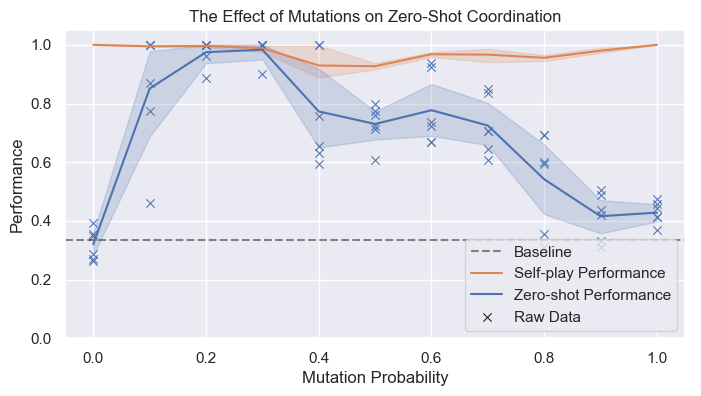

In [191]:
plt.figure(figsize=(8, 4))
ax = sns.lineplot(x=[-2, 2], y=[1/NUM_CLASSES, 1/NUM_CLASSES], 
                  color=(0.1, 0.1, 0.1, 0.5), label='Baseline')
ax.lines[0].set_linestyle("--")

sns.lineplot(x='Mutation Probability', y='Self-play Performance', 
             data=self_play_df, label='Self-play Performance', color=sns.color_palette()[1])

sns.lineplot(x='Mutation Probability', y='Zero-Shot Coordination Score', 
             data=zs_coord_df, label='Zero-shot Performance', palette=sns.color_palette()[0])
sns.scatterplot(x='Mutation Probability', y='Zero-Shot Coordination Score', 
                data=zs_coord_df, marker='x', palette=sns.color_palette()[0])

# sns.scatterplot(x='Mutation Probability', y='Self-play Performance', data=self_play_df, marker='x')
sns.scatterplot(x='x', y='y', data=pd.DataFrame([{'x': 100, 'y': 100}]), 
                color=(0.1, 0.1, 0.1, 0.5), marker='x', label='Raw Data')
plt.ylim([0, 1.05])
plt.xlim([-.05, 1.05])
plt.title('The Effect of Mutations on Zero-Shot Coordination')
plt.ylabel('Performance')
plt.xlabel('Mutation Probability')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(loc=4)
plt.show()

In [182]:
sns.lineplot?

In [71]:
 vary_pm_experiment.experiments[0]['experiment'].experiments[0]['experiment'].results

{'training_params_results': {'mean_test_loss': 1.0000001192092896,
  'mean_ground_truth_f1': 1.0,
  'ground_truth_acc': 1.0,
  'mean_student_error': 1.1920928955078125e-07,
  'mean_teacher_error': 1.1920928955078125e-07,
  'mean_protocol_diversity': 1.0,
  'mean_protocol_entropy': 7.222239013367687e-35},
 'vanilla_params_results': {'mean_test_loss': 1.0000001192092896,
  'mean_ground_truth_f1': 1.0,
  'ground_truth_acc': 1.0,
  'mean_student_error': 1.1920928955078125e-07,
  'mean_teacher_error': 1.1920928955078125e-07,
  'mean_protocol_diversity': 1.0,
  'mean_protocol_entropy': 7.222239013367687e-35},
 'student_responsiveness': 0.005685706957171926,
 'teacher_responsiveness': 0.0001086057031822998}

In [192]:
eval_metrics_df = pd.DataFrame([
    {
        'Mutation Probability': item_1['p_mutate'],
        'Teacher Responsiveness': item_2['experiment'].results['teacher_responsiveness'],
        'Student Responsiveness': item_2['experiment'].results['student_responsiveness'],
        'Protocol Diversity': item_2['experiment'].results['vanilla_params_results']['mean_protocol_diversity']
    }
    for item_1 in vary_pm_experiment.experiments
    if item_1['status'] == 'Complete'
    for item_2 in item_1['experiment'].experiments
    if item_2['status'] == 'Complete'
])

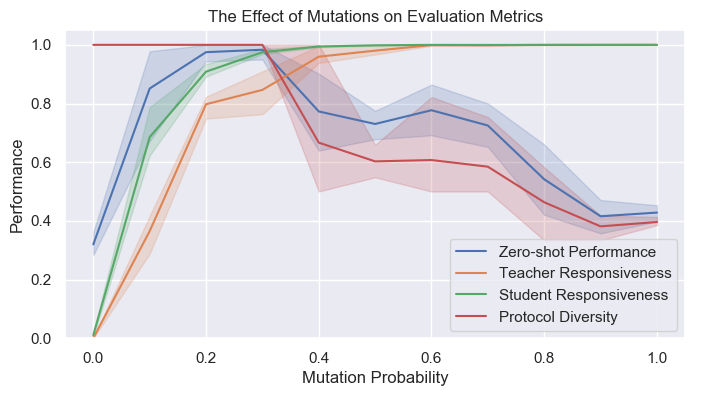

In [193]:
plt.figure(figsize=(8, 4))
# ax = sns.lineplot(x=[-2, 2], y=[1/NUM_CLASSES, 1/NUM_CLASSES], color=(0.1, 0.1, 0.1, 0.5), label='Baseline')
# ax.lines[0].set_linestyle("--")


sns.lineplot(x='Mutation Probability', y='Zero-Shot Coordination Score', 
             data=zs_coord_df, label='Zero-shot Performance')
sns.lineplot(x='Mutation Probability', y='Teacher Responsiveness', 
             data=eval_metrics_df, label='Teacher Responsiveness')
sns.lineplot(x='Mutation Probability', y='Student Responsiveness', 
             data=eval_metrics_df, label='Student Responsiveness')
sns.lineplot(x='Mutation Probability', y='Protocol Diversity', 
             data=eval_metrics_df, label='Protocol Diversity')

plt.ylim([0, 1.05])
plt.xlim([-.05, 1.05])
plt.title('The Effect of Mutations on Evaluation Metrics')
plt.ylabel('Performance')
plt.xlabel('Mutation Probability')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(loc=4)
plt.show()

In [210]:
zs_coord_df[zs_coord_df['Mutation Probability'] == 0.3].describe()

,Mutation Probability,Zero-Shot Coordination Score
count,6.0,6.000000
mean,0.3,0.983333
std,0.0,0.040825
min,0.3,0.900000
25%,0.3,1.000000
50%,0.3,1.000000
75%,0.3,1.000000
max,0.3,1.000000


In [22]:
zs_coord_df[zs_coord_df['Mutation Probability'] == 1.0].describe()

,Mutation Probability,Zero-Shot Coordination Score
count,6.0,6.000000
mean,1.0,0.465625
std,0.0,0.047228
min,1.0,0.393750
25%,1.0,0.437500
50%,1.0,0.478125
75%,1.0,0.495312
max,1.0,0.518750


In [213]:
df_train = pd.DataFrame([
    {
        'Epoch': epoch,
        '$p_m$': item_1['p_mutate'],
#         'Subexperiment': f'subexperiment_{i * len(vary_pm_experiment.experiments ) + j}',
        'Train Loss': training_item['loss']
    }
    for i, item_1 in enumerate(vary_pm_experiment.experiments + [old_point_four_experiment_2])
    for j, item_2 in enumerate(item_1['experiment'].experiments)
    for epoch, training_item in enumerate(item_2['experiment'].training_history) 
])
df_train.head()

,Epoch,$p_m$,Train Loss
0,0,0.0,3.829671
1,1,0.0,3.826695
2,2,0.0,3.807629
3,3,0.0,3.788617
4,4,0.0,3.721666


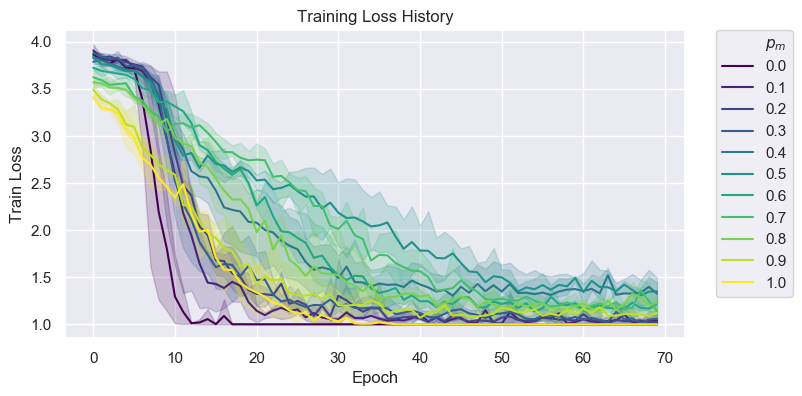

In [214]:
plt.figure(figsize=(8, 4))
lines = sns.lineplot(x='Epoch', y='Train Loss', hue='$p_m$', 
                     data=df_train, palette='viridis', legend='full');

# Put the legend out of the figure
# plt.colorbar(lines)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Training Loss History')
plt.show()

In [199]:
df_test = pd.DataFrame([
    {
        'Epoch': epoch,
        '$p_m$':item_1['p_mutate'],
        'Subexperiment': f'subexperiment_{item_2["index"]}',
        'Performance': training_item['test_metrics']['mean_ground_truth_f1'],
        'Protocol Diversity': training_item['test_metrics']['mean_protocol_diversity'],
    }
    for item_1 in vary_pm_experiment.experiments
    for item_2 in item_1['experiment'].experiments
    for epoch, training_item in enumerate(item_2['experiment'].training_history)
    if 'test_metrics' in training_item
])

In [207]:
df_test['$p_m$'].describe()

count    513.000000
mean       0.500000
std        0.317461
min        0.000000
25%        0.200000
50%        0.500000
75%        0.800000
max        1.000000
Name: $p_m$, dtype: float64

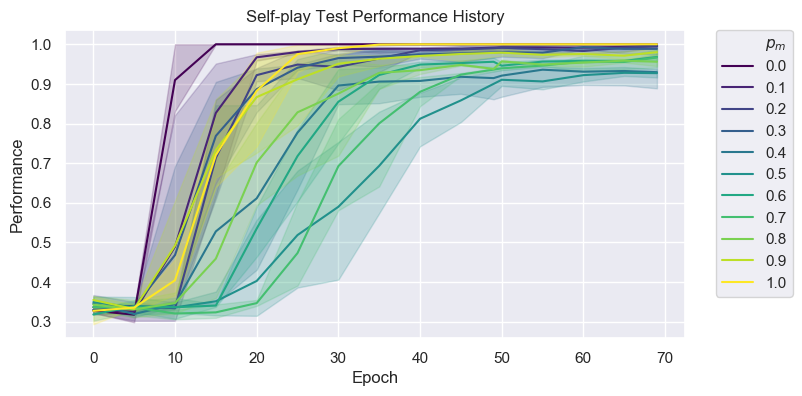

In [209]:
plt.figure(figsize=(8, 4))
lines = sns.lineplot(x='Epoch', y='Performance', hue='$p_m$', 
                     data=df_test, palette='viridis', legend='full');

# Put the legend out of the figure
# plt.colorbar(lines)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Self-play Test Performance History')
plt.show()

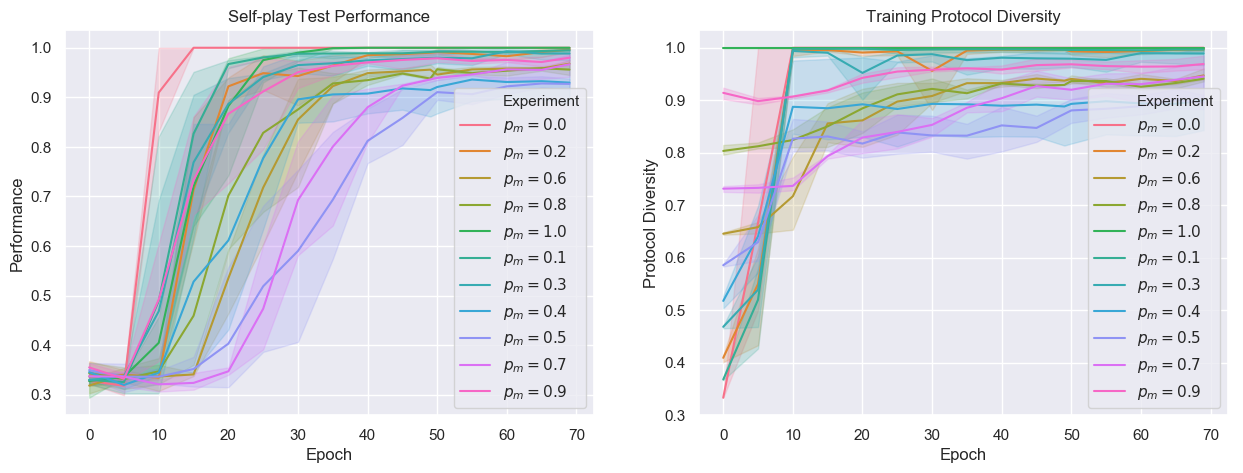

In [198]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x='Epoch', y='Performance', hue='Experiment', 
             data=df_test, ax=axs[0]);
sns.lineplot(x='Epoch', y='Protocol Diversity', hue='Experiment', 
             data=df_test, ax=axs[1]);
#              data=df_test[df_test['Experiment'] == 'p_m=0.2']);
# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[0].set_title('Self-play Test Performance')
axs[1].set_title('Training Protocol Diversity')
plt.show()

In [ ]:
exp = vary_pm_experiment.experiments[2]['experiment'].experiments[1]['experiment']
games_played, test_metrics = exp.run_tests()
test_metrics

In [ ]:
for i in range(5):
    inputs, targets, outputs = games_played[i]
    plot_game(inputs, outputs, targets, select_batch=2)

In [ ]:
num_meta_experiments = len(vary_pm_experiment.experiments)
exps_per_meta = len(vary_pm_experiment.experiments[0]['experiment'].experiments)

def make_cm_map_for_exp(i, j):
    meta_exp = vary_pm_experiment.experiments[i]['experiment']
    sub_exp = meta_exp.experiments[j]['experiment']
    games_played, _ = sub_exp.run_tests()
    return create_mean_class_message_map(games_played)

class_message_maps = [[make_cm_map_for_exp(i, j) for j in range(exps_per_meta)] 
                      for i in range(num_meta_experiments)]

In [ ]:
def plot_protocol_maps(maps, ylabel='Class', yticklabels=None):
    fig = plt.figure(figsize=(2*2*exps_per_meta, 2*num_meta_experiments)) 

    sqrs_per_plot = 5
    gs = gridspec.GridSpec(num_meta_experiments, sqrs_per_plot*exps_per_meta+1)
    
    yticklabels = yticklabels or [i+1 for i in range(NUM_CLASSES)]

    for i in range(num_meta_experiments):
        meta_exp = vary_pm_experiment.experiments[i]['experiment']
        for j in range(exps_per_meta):
            sub_exp = meta_exp.experiments[j]['experiment']
            ax = plt.subplot(gs[i, sqrs_per_plot*j:sqrs_per_plot*(j+1)])

            last_col = j == exps_per_meta - 1
            cbar_ax = plt.subplot(gs[i, -1]) if last_col else None

            sns.heatmap(maps[i][j], vmin=0, vmax=1, ax=ax, 
                        cbar=last_col, cbar_ax=cbar_ax);

            if j == 0: 
                p_mutate = sub_exp.get_play_params().get('p_mutate', 0.0) 
                ax.set_ylabel(f'$p_m = {p_mutate}$\n\n{ylabel}')
                ax.set_yticklabels(yticklabels)
            else: 
                ax.set_yticks([])

            if i == 0:
                ax.set_title(f'Experiment {j+1}')
                ax.set_xticks([])
            elif i == num_meta_experiments - 1:
                ax.set_xlabel('Symbol')
            else:
                ax.set_xticks([])

    plt.tight_layout()
    plt.show()

In [ ]:
plot_protocol_maps(class_message_maps)

In [ ]:
def make_im_map_for_exp(i, j):
    meta_exp = vary_pm_experiment.experiments[i]['experiment']
    sub_exp = meta_exp.experiments[j]['experiment']
    games_played, _ = sub_exp.run_tests()
    return create_mean_index_message_map(games_played)

index_message_maps = [[make_im_map_for_exp(i, j) for j in range(exps_per_meta)] 
                      for i in range(num_meta_experiments)]

In [ ]:
plot_protocol_maps(index_message_maps, ylabel='Time Step Index', yticklabels=[0, 1, 2])

In [ ]:
n_rows = 2
fig = plt.figure(figsize=(2*2*exps_per_meta, 2*n_rows))

sqrs_per_plot = 5
gs = gridspec.GridSpec(n_rows, sqrs_per_plot*exps_per_meta+1)

yticklabels = [i+1 for i in range(NUM_CLASSES)]


maps = [class_message_maps[0]] + [index_message_maps[0]]

for i in range(2):
    for j in range(exps_per_meta):
        
        last_col = j == exps_per_meta - 1
        cbar_ax = plt.subplot(gs[i, -1]) if last_col else None
        ax = plt.subplot(gs[i, sqrs_per_plot*j:sqrs_per_plot*(j+1)])

        sns.heatmap(maps[i][j], vmin=0, vmax=1, ax=ax, 
                    cbar=last_col, cbar_ax=cbar_ax);

        if j == 0 and i == 0: 
            ax.set_ylabel('Class')
            ax.set_yticklabels([1, 2, 3])
        elif j == 0 and i == 1:
            ax.set_ylabel('Time Step Index')
            ax.set_yticklabels([0, 1, 2])
        else:
            ax.set_yticks([])

        if i == 0:
            ax.set_title(f'Experiment {j+1}')
            ax.set_xticks([])
        elif i == 1:
            ax.set_xlabel('Symbol')

plt.tight_layout()
plt.show();

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(5, 3))
cols = 11
gs = gridspec.GridSpec(1, cols)

ax = plt.subplot(gs[0, :cols//2])
cbar_ax = plt.subplot(gs[0, -1])

sns.heatmap(tf.transpose(maps[0][0]), vmin=0, vmax=1, ax=ax, 
            cbar=last_col, cbar_ax=axs[2]);

ax.set_xlabel('Class')
ax.set_xticklabels([1, 2, 3])
ax.set_ylabel('Symbol')

ax = plt.subplot(gs[0, cols//2:-1])

sns.heatmap(tf.transpose(maps[1][0]), vmin=0, vmax=1, ax=ax, 
            cbar=last_col, cbar_ax=cbar_ax);
ax.set_xlabel('Time Step Index')
ax.set_xticklabels([0, 1, 2])
ax.set_yticks([])
# ax.set_ylabel('Symbol')

# if i == 0:
#     ax.set_title(f'Experiment {j+1}')
#     ax.set_xticks([])
# elif i == 1:
# sns.lineplot(x='Epoch', y='Performance', hue='Experiment', 
#              data=df_test, ax=axs[0]);
# sns.lineplot(x='Epoch', y='Protocol Diversity', hue='Experiment', 
#              data=df_test, ax=axs[1]);
#              data=df_test[df_test['Experiment'] == 'p_m=0.2']);
# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.title('Protocol Visu')
plt.show()

In [ ]:
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class')
plt.show()